In [1]:
#Disabling auto-scroll of outputs

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))

In [2]:
from datetime import datetime
start_time = datetime.now()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import nltk
import seaborn as sns
import re
import string 
import gensim.downloader as api
from autocorrect import Speller
from wordcloud import WordCloud
from emot.emo_unicode import UNICODE_EMO, EMOTICONS, EMOTICONS_EMO
from collections import Counter
from num2words import num2words
from nltk import word_tokenize, pos_tag
from nltk.tokenize import word_tokenize,TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from pycontractions import Contractions
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
# Handle date time conversions between pandas and matplotlib
#from pandas.plotting import register_matplotlib_converters
#register_matplotlib_converters()
from cycler import cycler
stop_words = set(stopwords.words('english'))

%matplotlib inline

In [4]:
train1 = pd.read_csv("Corona_NLP_train.csv", delimiter=',', encoding= 'ISO-8859-1')
test = pd.read_csv("Corona_NLP_test.csv", delimiter=',', encoding= 'ISO-8859-1')
#data = [train1, test]

#train = pd.concat(data)
train= train1
#print(train1.isna().sum(), test.isna().sum())
print(train1.OriginalTweet.str.isalpha().sum())

0


In [5]:
train['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [6]:
#"Extremely Negative": -1, "Negative": -1, "Neutral": 0, "Positive": 1, "Extremely Positive": 1

def change_values(string):
    if string == "Extremely Negative":
        return 0
    elif string == "Negative":
        return 0
    elif string == "Positive":
        return 2 
    elif string == "Extremely Positive":
        return 2
    elif string == "Neutral":
        return 1 
    
train['Sentiment'] = train['Sentiment'].apply(change_values)

#Probability
n0 = train['Sentiment'].value_counts()[0]
n1 = train['Sentiment'].value_counts()[1]
n2 = train['Sentiment'].value_counts()[2]
n = n0 + n1 +n2

p0 = n0 / n
p1 = n1 / n 
p2 = n2 / n

print("Probability a priori for class\t Negative : {}\t Neutral : {}\t Positive: {}".format(
     round(p0, 3), round(p1, 3), round(p2, 3)))

Probability a priori for class	 Negative : 0.374	 Neutral : 0.187	 Positive: 0.438


In [7]:
#Drop 'ScreenName', 'Location', 'TweetAt' Columns
train = train.drop(['ScreenName', 'TweetAt'], axis=1)
#pd.set_option('display.max_colwidth', -1)
#print(train)

In [8]:
#print (train['TweetAt'])
'''date1 = pd.to_datetime(train['TweetAt'], errors='coerce', 
                       format='%d/%m/%Y')
date2 = pd.to_datetime(train['TweetAt'], errors='coerce',
                       format='%d-%m-%Y')
train['TweetAt'] = date1.fillna(date2)
print (train['TweetAt'])'''

"date1 = pd.to_datetime(train['TweetAt'], errors='coerce', \n                       format='%d/%m/%Y')\ndate2 = pd.to_datetime(train['TweetAt'], errors='coerce',\n                       format='%d-%m-%Y')\ntrain['TweetAt'] = date1.fillna(date2)\nprint (train['TweetAt'])"

In [9]:
#Counter columns

#train['count_sentences']=train['OriginalTweet'].str.count('[\w][\.!\?]').clip(lower=1)
train['count_words'] = train['OriginalTweet'].apply(lambda x: 
                                    len(str(x).split()))
train['count_unique_words'] = train['OriginalTweet'].apply(lambda x: 
                                    len(set(str(x).split())))
train['count_letters'] = train['OriginalTweet'].apply(lambda x: 
                                    len(str(x)))
train['count_stopwords'] = train['OriginalTweet'].apply(lambda x: 
        len([w for w in str(x).lower().split() if w in stop_words]))
train['mean_word_len'] = train['OriginalTweet'].apply(lambda x: 
                        np.mean([len(w) for w in str(x).split()]))
train['count_mentions'] = train['OriginalTweet'].str.findall(
                 r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)').str.len()
train['count_hashtags'] = train['OriginalTweet'].str.findall(
                        r'#([A-Za-z0-9_]+)').str.len()
train['count_words_upper'] = train['OriginalTweet'].apply(lambda x: 
                    len([w for w in str(x).split() if w.isupper()]))
train['count_words_title'] = train['OriginalTweet'].apply(lambda x: 
                    len([w for w in str(x).split() if w.istitle()]))
train['count_excl_quest_marks'] = train['OriginalTweet'].str.findall(
                        r'(!|\?)').str.len()
train['count_urls'] = train['OriginalTweet'].str.findall(
                        r'http\S+|www\S+|https\S+').str.len()

#print(train['count_sentences'].head(20))
#punctuation count
#twitter_data["count_punctuations"] =twitter_data["full_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

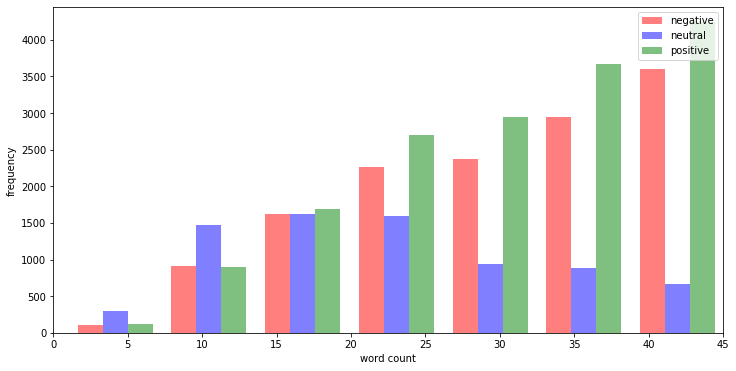

In [10]:
# plot word count distribution for positive, neutral and negative sentiments
x = train['count_words'][train.Sentiment == 0]
y = train['count_words'][train.Sentiment == 1]
z = train['count_words'][train.Sentiment == 2]
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y, z], color=['r','b', 'g'], alpha=0.5, label=['negative', 'neutral', 'positive'])
plt.legend(loc='upper right')

In [11]:
#&amp; removal to and
train['EditedTweet'] = train['OriginalTweet'].replace(
                r'&amp;', ' and ', regex=True)
train['EditedTweet'] = train['EditedTweet'].replace(
                r'&lt;', ' ', regex=True)
train['EditedTweet'] = train['EditedTweet'].replace(
                r'&gt;', ' ', regex=True)
print(train['EditedTweet'][3])






#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j


In [12]:
#non-ASCII character removal
#train['EditedTweet'] = train['OriginalTweet'].replace(
 #               r'Ã‚Â', "'", regex=True)
train['EditedTweet'] = train['EditedTweet'].str.encode('ascii', 
                            'ignore').str.decode('ascii')
print(train['EditedTweet'][68])
print(train['EditedTweet'][2098])

@TinaMcCauley70 Yeah my parents are risky people to the covid 19 thats why we stay at home just go to the supermarket when really necessary.. stay safe too ....
Food banks forced to close amid coronavirus outbreak https://t.co/ChGUNZPP4W Independent #Corona #wiwt #Covid19 #friday #update #who #tbt


In [13]:
#Link replacement
train['EditedTweet'] = train['EditedTweet'].replace(
                r'http\S+|www\S+|https\S+', ' <url> ', regex=True)
print(train['EditedTweet'][0])

@MeNyrbie @Phil_Gahan @Chrisitv  <url>  and  <url>  and  <url> 


In [14]:
#Mention replacement (with e-mail handling)
train['EditedTweet'] = train['EditedTweet'].replace(
    r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)', ' <user> ', regex=True)
pd.set_option('display.max_colwidth', -1)
print(train['EditedTweet'][0])

 <user>   <user>   <user>   <url>  and  <url>  and  <url> 


In [15]:
#Hashtag replacement
train['EditedTweet'] = train['EditedTweet'].replace(
    r'#([A-Za-z0-9_]+)', ' <hashtag> ', regex=True)
#    r'([#])','', regex=True)
print(train[train['UserName']==3802])

   UserName Location  \
3  3802      NaN       

                                                                                                                                                                                                                                                                                                                       OriginalTweet  \
3  My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j   

   Sentiment  count_words  count_unique_words  count_letters  count_stopwords  \
3  2          42           39                  306            19                

   mean_word_len  count_mentions  count_hashtags  count_words_upper  \
3  6.0            0               7               10        

In [16]:
#removal of more of two consequtive characters
train['EditedTweet'] = train['EditedTweet'].str.replace(r'(.)\1+', r'\1\1')
print(train['EditedTweet'][8])

Due to COVID-19 our retail store and classroom in Atlanta will not be open for walk-in business or classes for the next two weeks, beginning Monday, March 16.  We will continue to process online and phone orders as normal! Thank you for your understanding!  <url> 


In [17]:
'''EMOTICONS = {k: v for (k, v) in EMOTICONS.items() if v != 'Confusion'}

# Converting emojis to words
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(
                ",","").replace(":","").split()))
    return text
    
# Converting emoticons to words    
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "".join(EMOTICONS[emot].replace(
                ",","").split()), text)
    return text

# Passing both functions to 'EditedTweet'
train['EditedTweet'] = train['EditedTweet'].apply(convert_emoticons)
train['EditedTweet'] = train['EditedTweet'].apply(convert_emojis)
print(train['EditedTweet'][0])'''

'EMOTICONS = {k: v for (k, v) in EMOTICONS.items() if v != \'Confusion\'}\n\n# Converting emojis to words\ndef convert_emojis(text):\n    for emot in UNICODE_EMO:\n        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(\n                ",","").replace(":","").split()))\n    return text\n    \n# Converting emoticons to words    \ndef convert_emoticons(text):\n    for emot in EMOTICONS:\n        text = re.sub(u\'(\'+emot+\')\', "".join(EMOTICONS[emot].replace(\n                ",","").split()), text)\n    return text\n\n# Passing both functions to \'EditedTweet\'\ntrain[\'EditedTweet\'] = train[\'EditedTweet\'].apply(convert_emoticons)\ntrain[\'EditedTweet\'] = train[\'EditedTweet\'].apply(convert_emojis)\nprint(train[\'EditedTweet\'][0])'

In [18]:
#Contraction correction ex. wouldn't->would not 

#download the model we will use
model = api.load("glove-twitter-25")
cont = Contractions(kv_model=model)
train['EditedTweet'] = list(cont.expand_texts(train['EditedTweet'],precise=True))
print(train['EditedTweet'][8])

Due to COVID-19 our retail store and classroom in Atlanta will not be open for walk-in business or classes for the next two weeks, beginning Monday, March 16.  We will continue to process online and phone orders as normal! Thank you for your understanding!  <url> 


In [19]:
#number replacement
train['EditedTweet'] = train['EditedTweet'].str.replace(
   #  '(\d+(\.\d+)?)|(\d+(\,\d+)?)', r' <number> ') #add space 
    '(\d+\.\d+)|(\d+(\,\d+)*)', r' <number> ')

 

In [20]:
abbr_dict={
    "lol":"laughing out loud",
    "mkt":"market",
    "diy":"do it yourself",
    "u":"you",
    "gonna":"going to",
    "fav":"favorite",
    "btw":"by the way",
    "omg":"oh my god",
    "n":"and",
    "ppl":"people",
    "tv":"television",
    "ya":"yeah",
    "r":"are",
    "o":"oh",
    "pics":"pictures",
    "pic":"picture",
    " RT ":"retweet",
    "wtf":"what the fuck",
    "wanna":"want to",
    "kinda":"kind of",
    "ok":"okay",
    "ur":"your",
    "ya":"yeah",
    "pls":"please",
    "bc": "because",
    "fyi": "for your information",
    "dm": "direct message",
    "soo": "so",
    "Soo": "so",
    ":)": "<smile>",
    ":-)": "<smile>",
    ";)": "<smile>",
    ";-)": "<smile>",
    ":(": "<sadface>",
    ":-(": "<sadface>",
    ":'(": "<sadface>",
 
}

train['EditedTweet'] = train['EditedTweet'].apply(
    lambda x: ' '.join([abbr_dict.get(e, e) for e in x.split()]))

print(train['EditedTweet'][78])
print(train['EditedTweet'][8])
print(train['EditedTweet'][2053])

<user> <user> <user> <user> <user> <user> <user> This is both disgusting and disgraceful charging over inflated prices for items for stopping the spread of COVID- <number> , the government really needs to do something abou
Due to COVID- <number> our retail store and classroom in Atlanta will not be open for walk-in business or classes for the next two weeks, beginning Monday, March <number> . We will continue to process online and phone orders as normal! Thank you for your understanding! <url>
San Francisco. Line to get in to a grocery store. does not open until <number> pm Eastern. This is day one of <hashtag> and do not stand closer than <number> feet apart. <hashtag> <hashtag> <hashtag> <hashtag> <url>


In [21]:

#if tweet starts with ".", start sentence with the next character 
train['EditedTweet'] = train['EditedTweet'].apply(
    lambda x : x[1:] if x.startswith(".") else x)

#train['EditedTweet'] = train['EditedTweet'].str.replace(
#    r'([!"\$%&()*+,.\/:;=#@?\[\\\]^_`{|}~]+)', r' \1 ', regex=True)

train['EditedTweet'] = train['EditedTweet'].str.replace(
    r'([\-])',r' ', regex=True)


print(train[train['UserName']==4035])

'''#Punctuation removal

RE_PUNCTUATION = '|'.join([re.escape(x) for x in string.punctuation])
train["EditedTweet"] = train['EditedTweet'].str.replace(RE_PUNCTUATION, " ")'''
print(train['EditedTweet'][78])
print(train['EditedTweet'][8])

     UserName       Location  \
236  4035      San Diego, CA   

                                                                                                                                                                                                                                                    OriginalTweet  \
236  What's a good way to support grocery store, medical, and hospital staff during this time? I would normally think of something along the lines of ordering everyone pizza, but that doesn't seem like a great idea about now... #COVID2019 #COVID19 #COVID?19   

     Sentiment  count_words  count_unique_words  count_letters  \
236  2          41           39                  252             

     count_stopwords  mean_word_len  count_mentions  count_hashtags  \
236  14               5.170732       0               3                

     count_words_upper  count_words_title  count_excl_quest_marks  count_urls  \
236  4                  1                  2           

In [22]:
#Redundant space removal 
train['EditedTweet'] = train['EditedTweet'].replace('\s+', ' ', regex=True)
print(train['EditedTweet'][0])

<user> <user> <user> <url> and <url> and <url>


In [23]:
#auto-correct tweets 
#from textblob import TextBlob

check = Speller(lang='en')
train['EditedTweet'] = [' '.join([check(i) for i in x.split()]) for x in train['EditedTweet']]
#train['EditedTweet'] = train['EditedTweet'].apply(lambda x: ''.join(TextBlob(x).correct()))
#TextBlob(line).correct()
print(train['EditedTweet'][8])

Due to COVID <number> our retail store and classroom in Atlanta will not be open for walk in business or classes for the next two weeks, beginning Monday, March <number> . We will continue to process online and phone orders as normal! Thank you for your understanding! <url>


In [24]:
#Lowercase
train['EditedTweet'] = train['EditedTweet'].str.lower()
#print(train)

In [25]:
#Column of POS Tagged Sentences
tweet_tokenizer = TweetTokenizer()
train['pos_tagged_sent'] = train['EditedTweet'].apply(lambda x: 
                                    pos_tag(tweet_tokenizer.tokenize(x)))
print(train[train['UserName']==4035])


     UserName       Location  \
236  4035      San Diego, CA   

                                                                                                                                                                                                                                                    OriginalTweet  \
236  What's a good way to support grocery store, medical, and hospital staff during this time? I would normally think of something along the lines of ordering everyone pizza, but that doesn't seem like a great idea about now... #COVID2019 #COVID19 #COVID?19   

     Sentiment  count_words  count_unique_words  count_letters  \
236  2          41           39                  252             

     count_stopwords  mean_word_len  count_mentions  count_hashtags  \
236  14               5.170732       0               3                

     count_words_upper  count_words_title  count_excl_quest_marks  count_urls  \
236  4                  1                  2           

In [26]:
pos_counts =  pd.DataFrame(train['pos_tagged_sent'].map(lambda x: 
                                    Counter(tag[1] for tag in x)).to_list())
print(pos_counts)
print(train[train['UserName']==4035])


        JJ  NNP   CC   VB    NN   TO  PRP$  NNS  VBP   IN  ...  EX  ''  JJS  \
0      1.0  4.0  2.0  1.0 NaN   NaN  NaN   NaN  NaN  NaN   ... NaN NaN NaN    
1      6.0 NaN   1.0  1.0  9.0   2.0  1.0   8.0  2.0  5.0  ... NaN NaN NaN    
2      2.0  1.0 NaN   1.0  4.0   1.0 NaN    3.0 NaN   1.0  ... NaN NaN NaN    
3      9.0  4.0  1.0  3.0  7.0  NaN   1.0  NaN   3.0  3.0  ... NaN NaN NaN    
4      5.0  5.0  2.0  2.0  10.0  1.0  1.0  NaN   2.0  4.0  ... NaN NaN NaN    
...    ...  ...  ...  ...   ...  ...  ...   ..   ...  ...  ...  ..  ..  ..    
41152  1.0  3.0 NaN  NaN   4.0   1.0 NaN    2.0 NaN   1.0  ... NaN NaN NaN    
41153  3.0  1.0 NaN   2.0  4.0   2.0 NaN    1.0 NaN   3.0  ... NaN NaN NaN    
41154  2.0  4.0 NaN   1.0  2.0  NaN   1.0  NaN   1.0 NaN   ... NaN NaN NaN    
41155  2.0 NaN  NaN   1.0  5.0   1.0 NaN   NaN  NaN   3.0  ... NaN NaN NaN    
41156  4.0 NaN   1.0 NaN   13.0  1.0 NaN    2.0  2.0  7.0  ... NaN NaN NaN    

       UH  FW    $  RBS  WP$  SYM  ``  
0     NaN N

In [27]:
lemmatizer = nltk.stem.WordNetLemmatizer()
wordnet_lemmatizer = WordNetLemmatizer()

# POS tags to WordNet tags
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ""
    

train['Wordnet_tagged_sent'] = train['pos_tagged_sent'].apply(lambda x : 
                    [(w,nltk_tag_to_wordnet_tag(t)) for (w, t) in x],1)
print (train['Wordnet_tagged_sent'])

def lemmatize_sentence(sentence):
    lemmatized_sentence = []
    for word, tag in sentence:
        if tag is "":
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

# Lemmatizing
train['Preprocessed_sentences'] = train['Wordnet_tagged_sent'].apply(
    lambda x: lemmatize_sentence(x))
print (train['Preprocessed_sentences'])

wordnet_counts =  pd.DataFrame(train['Wordnet_tagged_sent'].map(lambda x: 
                                    Counter(tag[1] for tag in x)).to_list())
train = pd.concat([train, wordnet_counts], axis=1).fillna(0)
print (wordnet_counts)

0        [(<user>, a), (<user>, n), (<user>, n), (<url>, n), (and, ), (<url>, n), (and, ), (<url>, v)]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1        [(advice, n), (talk, n), (to, ), (your, ), (neighbours, n), (family, n), (to, ), (exchange, v), (phone, n), (numbers, n), (create, v), (contact, a), (list, n), (with, ), (phone, n), (numbers, n), (of, ), (neighbours, n), (schools, n), (employer, v), (chemist, a), (gt, n), (set, v), (up, r), (online, a), (shopping, n), (accounts, n), (if, ), (pos, a), (adequate, a), (supplies, n), (of, ), (regular, a), (mens, n

          a     n          v    r
0      1.0   4.0   2.0   1.0 NaN 
1      6.0   17.0  9.0   4.0  2.0
2      2.0   8.0   4.0   3.0 NaN 
3      10.0  11.0  16.0  8.0  4.0
4      5.0   15.0  20.0  7.0  3.0
...    ...    ...   ...  ...  ...
41152  1.0   9.0   2.0   1.0 NaN 
41153  3.0   6.0   8.0   6.0  3.0
41154  2.0   6.0   7.0   5.0  1.0
41155  2.0   5.0   8.0   4.0 NaN 
41156  5.0   15.0  17.0  9.0  7.0

[41157 rows x 5 columns]


In [28]:
#Renaming new columns
#train.rename(columns={ train.columns[7]: 'Other' }, inplace = True)
train.rename(columns={'' : 'Others', 'n': 'Nouns', 'v': 'Verbs', 
            'a': 'Adjectives', 'r': 'Adverbs'}, inplace=True)

cols = ["Others","Nouns","Verbs","Adjectives","Adverbs"]
train[cols] = train[cols].values.astype(np.int64)

In [29]:
#Tokenization of the lemmatized rows
'''
print(train['Lemmatize'])

train['Preprocessed_sentences'] = train.apply(lambda row: 
                        tweet_tokenizer.tokenize(row['Lemmatize']), axis=1)
#print(train['tokenized'])'''

"\nprint(train['Lemmatize'])\n\ntrain['Preprocessed_sentences'] = train.apply(lambda row: \n                        tweet_tokenizer.tokenize(row['Lemmatize']), axis=1)\n#print(train['tokenized'])"

In [30]:
print(train.head())

   UserName   Location  \
0  3799      London      
1  3800      UK          
2  3801      Vagabonds   
3  3802      0           
4  3803      0           

                                                                                                                                                                                                                                                                                                                        OriginalTweet  \
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8                                                                                                                                                                                                                      
1  advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if po

In [31]:
#Add new stopwords and remove all of them
'''
#new_stopwords = ['covid-', 'covid', 'coronavirus', '``']
new_stopwords = ['<hashtag>', '<number>', '<url>', '<user>']
stop_words = stop_words.union(new_stopwords)
#stop_words = stop_words - set(['not'])
train["tokenized"] = train['tokenized'].apply(lambda x: 
                            [item for item in x if item not in stop_words])

#print(Counter(" ".join(train["Tokens_w/ostop"]).split()).most_common(20))
#print(train.loc[[7689]])
'''

'\n#new_stopwords = [\'covid-\', \'covid\', \'coronavirus\', \'``\']\nnew_stopwords = [\'<hashtag>\', \'<number>\', \'<url>\', \'<user>\']\nstop_words = stop_words.union(new_stopwords)\n#stop_words = stop_words - set([\'not\'])\ntrain["tokenized"] = train[\'tokenized\'].apply(lambda x: \n                            [item for item in x if item not in stop_words])\n\n#print(Counter(" ".join(train["Tokens_w/ostop"]).split()).most_common(20))\n#print(train.loc[[7689]])\n'

In [32]:
'''train["Preprocessed_sentences"] = train["tokenized"].apply(lambda x:
                                                        " ".join(x))
print(train["Preprocessed_sentences"])'''

'train["Preprocessed_sentences"] = train["tokenized"].apply(lambda x:\n                                                        " ".join(x))\nprint(train["Preprocessed_sentences"])'

In [33]:
#Remove tweets with less than 2 words
#train['len_tokens'] = train['tokenized'].apply(lambda x: len(x))
#print(train['len_tokens'])
#0 = train['len_tokens'].value_counts()[0]
#n1 = train['len_tokens'].value_counts()[1]
#n2 = train['len_tokens'].value_counts()[2]
#print( n1+ n2)

#Remove rows that don't contain text after preprocessing
train = train[train['Preprocessed_sentences'].str.contains('[A-Za-z]', na=False)]
train = train.reset_index(drop=True)


In [34]:
#Save dataset

train.to_csv(r'preprocessed_tweets.csv')

In [35]:
print(train)

       UserName                      Location  \
0      3799      London                         
1      3800      UK                             
2      3801      Vagabonds                      
3      3802      0                              
4      3803      0                              
...     ...     ..                              
41152  44951     Wellington City, New Zealand   
41153  44952     0                              
41154  44953     0                              
41155  44954     0                              
41156  44955     i love you so much || he/him   

                                                                                                                                                                                                                                                                                                                            OriginalTweet  \
0      @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.c